In [109]:
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from data.prepare_data import *
from data.prepare_word2vec_ed import *
from manual_labeling.labeled_data import SLOVA_PO_B
from similarities.text_similarities import levenshtein_similarity

model = Word2Vec.load('utils/word2vec.model')
slova_po_b = pd.read_csv('data/processed/vyjmenovana_slova_po_b.csv')

# words which are also in my word2vec model and are labeled
X, word2vec_data = get_word2vec_items(model, slova_po_b)
label_data(word2vec_data, SLOVA_PO_B)
labeled_word2vec_data = word2vec_data[word2vec_data['manual_label'] != 0]

# all answers which are labeled
slova_po_b['full_solution'] = get_solutions(slova_po_b, 'full')
label_data(slova_po_b, SLOVA_PO_B)
labeled_slova_po_b = slova_po_b[slova_po_b['manual_label'] != 0]

# all answers which are also in my word2vec model and are labeled
labeled_slova_po_b = labeled_slova_po_b.loc[labeled_slova_po_b['question'].isin(labeled_word2vec_data['question'])]

In [110]:
# same assignment has two ids in the dataset => replace the id
# labeled_slova_po_b[labeled_slova_po_b['question'] == 'b_otop'].question_id.unique()
# -> array([6387,  237])
labeled_slova_po_b.loc[labeled_slova_po_b['question_id'] == 237] = 6387

In [111]:
### ED ###
edit1 = create_edit_similarity_matrix(labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'], levenshtein_similarity)
edit1 = edit1.astype(float)

### word2vec ###
word2vec = create_word2vec_similarity_matrix(model, labeled_word2vec_data['question_id'], labeled_word2vec_data['solution'])

### pearson ###
correctness_matrix = reshape_to_correctness_matrix(labeled_slova_po_b)
pearson1 = correctness_matrix_to_similarity_matrix('doublepearson', correctness_matrix)
pearson2 = correctness_matrix_to_similarity_matrix('pearson', correctness_matrix)

In [115]:
kmeans = KMeans(n_clusters=8)

In [116]:
# kmeans.fit_transform(pearson1)
kmeans.fit_predict(pearson1)

array([6, 6, 6, 6, 6, 2, 3, 2, 3, 1, 0, 0, 7, 0, 5, 7, 5, 5, 7, 7, 3, 4,
       2, 4, 4, 4, 2, 1, 3, 5, 1, 0, 0, 1, 2, 1, 4, 4, 1], dtype=int32)

In [117]:
kmeans.fit_predict(pearson2)

array([3, 3, 3, 3, 3, 7, 5, 1, 5, 4, 0, 0, 1, 0, 6, 7, 6, 6, 1, 1, 5, 2,
       7, 2, 2, 2, 1, 4, 4, 6, 5, 0, 0, 4, 1, 4, 2, 2, 4], dtype=int32)

In [118]:
kmeans.fit_predict(word2vec)

array([1, 4, 7, 4, 1, 4, 4, 1, 0, 0, 3, 0, 1, 2, 0, 0, 4, 4, 2, 1, 1, 7,
       4, 6, 5, 2, 0, 6, 6, 4, 4, 1, 5, 3, 5, 3, 3, 5, 5], dtype=int32)

In [119]:
kmeans.fit_predict(edit1)

array([6, 7, 7, 1, 6, 3, 1, 6, 3, 3, 4, 5, 5, 4, 5, 5, 3, 5, 4, 5, 6, 7,
       5, 0, 2, 0, 2, 0, 0, 3, 2, 4, 2, 3, 2, 2, 2, 2, 2], dtype=int32)

In [128]:
clusters = labeled_word2vec_data['manual_label'].unique()

In [129]:
len(clusters)

8

In [133]:
from sklearn.metrics import adjusted_rand_score

In [263]:
method = edit1
X = method
question_ids = X.index

In [177]:
labeled_slova_po_b = labeled_slova_po_b.set_index('question_id')

In [279]:
ground_truth = np.array([labeled_slova_po_b.at[question_id, 'manual_label'][0] for question_id in question_ids])

In [280]:
cluster_labels = kmeans.fit_predict(edit1)

In [281]:
adjusted_rand_score(ground_truth, cluster_labels)

0.7715192879821996

In [313]:
similarities = [('pearson', pearson2), ('doublepearson', pearson1), ('edit_distance', edit1), ('word2vec', word2vec)]
adj_randindex = []
for similarity_name, X in similarities:
    print(similarity_name)
    ground_truth = np.array([labeled_slova_po_b.at[question_id, 'manual_label'][0] for question_id in X.index])
    cluster_labels = kmeans.fit_predict(X)
    adj_randindex.append(adjusted_rand_score(ground_truth, cluster_labels))

pearson
doublepearson
edit_distance
word2vec


In [314]:
adj_randindex

[0.3852340904922843,
 0.44016604273308374,
 0.707605800532702,
 0.47344961240310074]

In [315]:
similarities = [name for name, _ in similarities]
data = {'similarity': similarities, 'randindex': adj_randindex}
df = pd.DataFrame(data)

In [316]:
df

,randindex,similarity
0,0.385234,pearson
1,0.440166,doublepearson
2,0.707606,edit_distance
3,0.473450,word2vec


In [340]:
%matplotlib inline

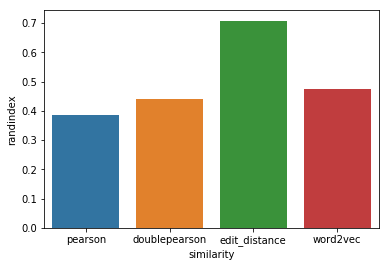

In [341]:
# df.plot(kind='bar', x='similarity', figsize=(8,5))
import seaborn as sns
sns.barplot(data=df, x='similarity', y='randindex')